In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable


# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/home/aussing/sty.mplstyle')

In [2]:
UNITMASS = 1e10
LITTLEH = 0.6688
UNIT_LENGTH_FOR_PLOTS = 'Mpc'
npart_min = 20
npart_star_min = 1
VR_color = '#8ec127'


In [3]:

def get_extent(halo_pos,extent):

    xmin,xmax  = halo_pos[0]-extent,halo_pos[0]+extent
    ymin,ymax  = halo_pos[1]-extent,halo_pos[1]+extent
    zmin,zmax  = halo_pos[2]-extent,halo_pos[2]+extent
    
    return xmin,xmax,ymin,ymax,zmin,zmax


In [4]:

def make_mask(pos_x,pos_y,pos_z,halo_pos,extent):
    xmin,xmax,ymin,ymax,zmin,zmax = get_extent(halo_pos,extent)
    
    x_mask = (pos_x>=xmin) & (pos_x<=xmax)
    y_mask = (pos_y>=ymin) & (pos_y<=ymax)
    z_mask = (pos_z>=zmin) & (pos_z<=zmax)
    
    pos_mask = x_mask & y_mask & z_mask

    return pos_mask

In [5]:
def get_sim_data(sim_directory,n_file):
    snap_fname     = f'/snapshot_{str(n_file).zfill(3)}.hdf5'
    snap_directory = sim_directory + snap_fname
    snap_data     = h5py.File(snap_directory, 'r')
    
    # haloinfo_fname     = f'/fof_tab_{str(i_file).zfill(3)}.hdf5'
    haloinfo_fname     = f'/fof_subhalo_tab_{str(n_file).zfill(3)}.hdf5'
    haloinfo_directory = sim_directory + haloinfo_fname
    haloinfo_data = h5py.File(haloinfo_directory, 'r')

    z = np.round(snap_data['Header'].attrs['Redshift'],2)
    return snap_data, haloinfo_data, z

In [6]:
def subhalo_data(sim_directory,i_file):
    snap_data, haloinfo_data, z = get_sim_data(sim_directory,i_file)
    z = np.round(z,2)
    print(z)
    # unit_len = get_unit_len(snap_data)

    halo_pos   = np.array(haloinfo_data['Group']['GroupPos'], dtype=np.float64) / LITTLEH
    halo_mass  = np.array(haloinfo_data['Group']['GroupMass'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_M200c = np.array(haloinfo_data['Group']['Group_M_Crit200'], dtype=np.float64) * UNITMASS / LITTLEH
    halo_masstypes = np.array(haloinfo_data['Group']['GroupMassType'], dtype=np.float64) * UNITMASS / LITTLEH
    R200c = np.array(haloinfo_data['Group']['Group_R_Crit200'], dtype=np.float64) / LITTLEH

    mass_mask = np.argsort(halo_M200c)[::-1]
    halo_mainID = np.where(halo_masstypes[mass_mask,5] == 0)[0][0]

    # print(f"Redshift = {np.round(z,2)}")
    # print(f"main halo ID = {mass_mask[halo_mainID]}")
    # print(f"Main halo pos = {halo_pos[mass_mask[halo_mainID],:]*LITTLEH}")
    # print(f'M_200c = {np.round(halo_M200c[mass_mask[halo_mainID]]/1e10,3)*LITTLEH}e10 h^-1 Msun')
    # print(f"R_200c = {np.round((R200c[mass_mask[halo_mainID]]),4)*LITTLEH} {UNIT_LENGTH_FOR_PLOTS}") # *unit_len set_plot_len

    main_halo_only = True
    subhalo_halo_num = np.array(haloinfo_data['Subhalo']['SubhaloGroupNr'], dtype=np.float64)
    subhalo_rank       = np.array(haloinfo_data['Subhalo']['SubhaloRankInGr'], dtype=np.int32)

    subhalo_mass       = np.array(haloinfo_data['Subhalo']['SubhaloMass'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_mass_type  = np.array(haloinfo_data['Subhalo']['SubhaloMassType'],dtype=np.float64) * UNITMASS / LITTLEH
    subhalo_len        = np.array(haloinfo_data['Subhalo']['SubhaloLen'],dtype=np.int32)
    subhalo_len_type   = np.array(haloinfo_data['Subhalo']['SubhaloLenType'],dtype=np.int32)
    subhalo_pos        = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 

    main_halo_subhalos = np.where(subhalo_halo_num==[mass_mask[halo_mainID]])

    subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 

    subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    ### This is a test to get every satellite
    # subhalo_mass       = subhalo_mass[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    # subhalo_mass_type  = subhalo_mass_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    # subhalo_len        = subhalo_len[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]
    # subhalo_len_type   = subhalo_len_type[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 

    subhalo_pos = np.array(haloinfo_data['Subhalo']['SubhaloPos'], dtype=np.float64) / LITTLEH 
    subhalo_pos = subhalo_pos[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0]

    # subhalo_pos_dif = subhalo_pos - halo_pos[mass_mask[halo_mainID],:]
    # print(f"subhalo rank 0 - {subhalo_pos[0,:]}")
    # print(f"subhalo rank 1 - {subhalo_pos[1,:]}\n")

    subhalo_dist = []
    for i in range(len(subhalo_pos)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = subhalo_pos[i] - halo_pos[mass_mask[halo_mainID],:]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))

    subhalo_dist = np.array(subhalo_dist)
    mask_dists = (subhalo_dist>0.01) #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))
    # print(subhalo_dist[mask_dists])
    test = subhalo_dist[mask_dists]

    mask = (subhalo_len>=npart_min) & (subhalo_len_type[:,4]>=npart_star_min) & (subhalo_dist>0.005)  #& (subhalo_dist<set_plot_len(R200c[mass_mask[halo_mainID]]*unit_len))

    # print(mask)
    star_mass              = subhalo_mass_type[mask,4]
    star_mass_ordered      = np.argsort(star_mass)[::-1]
    star_mass              = star_mass[star_mass_ordered][np.where(star_mass[star_mass_ordered]>0)[0]]
    star_mass_sum          = np.cumsum(np.ones(star_mass.shape[0]))
    
    subhalo_radius = np.array(haloinfo_data['Subhalo']['SubhaloHalfmassRad'],dtype=np.float64) #/ LITTLEH #* unit_len
    subhalo_radius = subhalo_radius[main_halo_subhalos][subhalo_rank[main_halo_subhalos]!=0] 
    
    return star_mass, star_mass_sum, z, subhalo_pos, subhalo_radius, R200c[mass_mask[halo_mainID]], subhalo_mass_type

In [7]:
sim_directory_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/'
sim_directory_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/'

sim_directory_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/'
sim_directory_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/'
i_file = 26
star_mass_cdm_005, star_mass_sum_cdm_005, z, subhalo_pos_cdm_005, subhalo_radius_cdm_005, r_200c_cdm_005, subhalo_mass_type_cdm_005 = subhalo_data(sim_directory_cdm_005,i_file)
star_mass_cdm_010, star_mass_sum_cdm_010, z, subhalo_pos_cdm_010, subhalo_radius_cdm_010, r_200c_cdm_010, subhalo_mass_type_cdm_010 = subhalo_data(sim_directory_cdm_010,i_file)

star_mass_wdm_005, star_mass_sum_wdm_005, z, subhalo_pos_wdm_005, subhalo_radius_wdm_005, r_200c_wdm_005, subhalo_mass_type_wdm_005 = subhalo_data(sim_directory_wdm_005,i_file)
star_mass_wdm_010, star_mass_sum_wdm_010, z, subhalo_pos_wdm_010, subhalo_radius_wdm_010, r_200c_wdm_010, subhalo_mass_type_wdm_010 = subhalo_data(sim_directory_wdm_010,i_file)

0.0
0.0
0.0
0.0


In [8]:
def AHF_data(ahf_halos):
    ahf_cols = []
    with open(ahf_halos) as ahf_f:
        aux_ahf_cols = ahf_f.readline()[1:].split('\t')
        for el in aux_ahf_cols:
            ahf_cols.append(el.rpartition('(')[0])
    ahf_cols = ahf_cols[:-1]
    ahf_cols = np.array(ahf_cols)

    ahf_dat = pd.read_table(ahf_halos,delim_whitespace=True,names=ahf_cols,header=0)

    # print(np.sort(ahf_cols[:]))
    
    mainhaloes = ahf_dat[(ahf_dat['hostHalo']==0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)].sort_values('Mhalo',ascending=False)

    halo_mass_ahf = mainhaloes['Mhalo'] / LITTLEH
    main_halo_pos = np.array((mainhaloes['Xc'].iloc[0] ,mainhaloes['Yc'].iloc[0] / 1,mainhaloes['Zc'].iloc[0] / 1)) / 1e3 / LITTLEH
    # print(f"AHF halo mass = {mainhaloes['Mhalo'].iloc[0] / LITTLEH / UNITMASS }e10 Msun")
    # print(f"AHF halo radius = {mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3} Mpc")
    print(f"AHF concentration = {mainhaloes['cNFW'].iloc[0]}")
    # print(f"AHF halo pos = {main_halo_pos}")

    subhaloes = ahf_dat[(ahf_dat['hostHalo']!=0) & (ahf_dat['fMhires']==1) & (ahf_dat['npart']>npart_min)]
    print(f"Total subhaloes in the box = {len(subhaloes)}")
    MH_subhaloes = subhaloes[subhaloes['hostHalo']==mainhaloes['ID'].iloc[0]]
    print(f"Total Main Halo Subhaloes = {len(MH_subhaloes)}")
    xpos = MH_subhaloes['Xc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    ypos = MH_subhaloes['Yc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    zpos = MH_subhaloes['Zc'] / 1e3 / LITTLEH   # [MH_subhaloes['M_star']>0]
    positions = np.column_stack((xpos,ypos,zpos)) 
    subhalo_dist = []
    for i in range(len(positions)):
        # print(positions[i])
        # print((positions-main_halo_pos)[i])
        subhalo_pos_dif = (positions-main_halo_pos)[i]
        subhalo_dist.append(np.sqrt(subhalo_pos_dif[0]**2+subhalo_pos_dif[1]**2+subhalo_pos_dif[2]**2))
        # print()

    
    subhalo_dist = np.array(subhalo_dist)
    # print(subhalo_dist[subhalo_dist>0.01])
    # print(MH_subhaloes['M_star'][MH_subhaloes['M_star']>0][subhalo_dist<0.01])
    
    mask_ahf = (MH_subhaloes['M_star']>0) & (MH_subhaloes['n_star']>=npart_star_min) & (subhalo_dist>0.005) #& (subhalo_dist<mainhaloes['Rhalo'].iloc[0] / LITTLEH / 1e3)
    
    MH_subhaloes_sorted = np.sort(MH_subhaloes['M_star'][mask_ahf])[::-1] / LITTLEH
    subhalo_cummass_func_ahf = np.cumsum(np.ones(len(MH_subhaloes_sorted)))

    # MW_all_subhaloes = np.sort((MH_subhaloes['Mhalo'] - MH_subhaloes['M_star']- MH_subhaloes['M_gas']))[::-1] / LITTLEH # 
    MW_all_subhaloes = np.sort((MH_subhaloes['Mhalo']))[::-1] / LITTLEH # 
    all_subhalo_cummass_func_ahf = np.cumsum(np.ones(len(MW_all_subhaloes)))

    return MH_subhaloes_sorted, subhalo_cummass_func_ahf, MW_all_subhaloes, all_subhalo_cummass_func_ahf

In [9]:
# ahf_halos_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
# ahf_halos_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

# ahf_halos_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/ahf/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
# ahf_halos_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/ahf/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

ahf_halos_cdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_005/ahf_test/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_cdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/cdm/zoom/output/sn_010/ahf_test/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

ahf_halos_wdm_005 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_005/ahf_test/AHF.N2048_L65_sd46371-sn_005.snap_026.z0.000.AHF_halos'
ahf_halos_wdm_010 = '/fred/oz217/aussing/N2048_L65_sd46371/wdm_3.5/zoom/output/sn_010/ahf_test/AHF.N2048_L65_sd46371-sn_010.snap_026.z0.000.AHF_halos'

MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005, MW_all_subhaloes_cdm_005, all_subhalo_cummass_func_ahf_cdm_005 = AHF_data(ahf_halos_cdm_005)
MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010, MW_all_subhaloes_cdm_010, all_subhalo_cummass_func_ahf_cdm_010 = AHF_data(ahf_halos_cdm_010)

MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005, MW_all_subhaloes_wdm_005, all_subhalo_cummass_func_ahf_wdm_005 = AHF_data(ahf_halos_wdm_005)
MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010, MW_all_subhaloes_wdm_010, all_subhalo_cummass_func_ahf_wdm_010 = AHF_data(ahf_halos_wdm_010)

AHF concentration = 20.9326
Total subhaloes in the box = 2338
Total Main Halo Subhaloes = 152
AHF concentration = 44.7961
Total subhaloes in the box = 2219
Total Main Halo Subhaloes = 150
AHF concentration = 25.0439
Total subhaloes in the box = 790
Total Main Halo Subhaloes = 60
AHF concentration = 25.7214
Total subhaloes in the box = 765
Total Main Halo Subhaloes = 56


In [11]:
# VR_out_dir_cdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/N2048_L65_sd46371/cdm_sn_005/out'
# VR_out_dir_cdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/N2048_L65_sd46371/cdm_sn_010/out'
# VR_out_dir_wdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/N2048_L65_sd46371/wdm_sn_005/out'
# VR_out_dir_wdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/N2048_L65_sd46371/wdm_sn_010/out'

# VR_out_dir_cdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_1/test'
VR_out_dir_cdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_1/test'
# VR_out_dir_wdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_1/test'
# VR_out_dir_wdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_1/test'

# VR_out_dir_cdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_2/cdm_sn_005/test'
# VR_out_dir_cdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_2/cdm_sn_010/test'
# VR_out_dir_wdm_sn_005 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_2/wdm_sn_005/test'
# VR_out_dir_wdm_sn_010 = '/fred/oz217/aussing/VELOCIraptor-STF/output/b_srch_2/wdm_sn_010/test'




# VR_halo_data_cdm_005    = h5py.File(f'{VR_out_dir_cdm_sn_005}.properties', 'r')
# VR_halo_info_cdm_005    = h5py.File(f'{VR_out_dir_cdm_sn_005}.catalog_groups', 'r')
# VR_subhalo_data_cdm_005 = h5py.File(f'{VR_out_dir_cdm_sn_005}.sublevels.properties', 'r')
# VR_subhalo_info_cdm_005 = h5py.File(f'{VR_out_dir_cdm_sn_005}.sublevels.catalog_groups', 'r')

VR_halo_data_cdm_010    = h5py.File(f'{VR_out_dir_cdm_sn_010}.properties', 'r')
VR_halo_info_cdm_010    = h5py.File(f'{VR_out_dir_cdm_sn_010}.catalog_groups', 'r')
VR_subhalo_data_cdm_010 = h5py.File(f'{VR_out_dir_cdm_sn_010}.sublevels.properties', 'r')
VR_subhalo_info_cdm_010 = h5py.File(f'{VR_out_dir_cdm_sn_010}.sublevels.catalog_groups', 'r')

# VR_halo_data_wdm_005    = h5py.File(f'{VR_out_dir_wdm_sn_005}.properties', 'r')
# VR_halo_info_wdm_005    = h5py.File(f'{VR_out_dir_wdm_sn_005}.catalog_groups', 'r')
# VR_subhalo_data_wdm_005 = h5py.File(f'{VR_out_dir_wdm_sn_005}.sublevels.properties', 'r')
# VR_subhalo_info_wdm_005 = h5py.File(f'{VR_out_dir_wdm_sn_005}.sublevels.catalog_groups', 'r')

# VR_halo_data_wdm_010    = h5py.File(f'{VR_out_dir_wdm_sn_010}.properties', 'r')
# VR_halo_info_wdm_010    = h5py.File(f'{VR_out_dir_wdm_sn_010}.catalog_groups', 'r')
# VR_subhalo_data_wdm_010 = h5py.File(f'{VR_out_dir_wdm_sn_010}.sublevels.properties', 'r')
# VR_subhalo_info_wdm_010 = h5py.File(f'{VR_out_dir_wdm_sn_010}.sublevels.catalog_groups', 'r')

In [12]:
def get_VR_subs(vel_subhalo_data,vel_subhalo_info):
    subhalo_parent_id = np.array(vel_subhalo_info['Parent_halo_ID'],dtype=int)-1
    test_id = 0
    mask = np.where(subhalo_parent_id==test_id)[0]
    
    sub_mass = vel_subhalo_data['Mass_tot'][mask]*1e10
    sub_mass_gas = vel_subhalo_data['Mass_gas'][mask]*1e10
    sub_mass_star = vel_subhalo_data['Mass_star'][mask]*1e10

    return sub_mass, sub_mass_gas, sub_mass_star


In [ ]:
# sub_mass_cdm_005, sub_mass_gas_cdm_005, sub_mass_star_cdm_005 = get_VR_subs(VR_subhalo_data_cdm_005,VR_subhalo_info_cdm_005)

sub_mass_cdm_010, sub_mass_gas_cdm_010, sub_mass_star_cdm_010 = get_VR_subs(VR_subhalo_data_cdm_010,VR_subhalo_info_cdm_010)
# sub_mass_wdm_005, sub_mass_gas_wdm_005, sub_mass_star_wdm_005 = get_VR_subs(VR_subhalo_data_wdm_005,VR_subhalo_info_wdm_005)

# sub_mass_wdm_010, sub_mass_gas_wdm_010, sub_mass_star_wdm_010 = get_VR_subs(VR_subhalo_data_wdm_010,VR_subhalo_info_wdm_010)



In [ ]:
DM_subs_VR_cdm_005 = (sub_mass_cdm_005)/LITTLEH
DM_subs_VR_cdm_005 = np.sort(DM_subs_VR_cdm_005)[::-1]
DM_subs_VR_cdm_005_sum = np.cumsum(np.ones(len(DM_subs_VR_cdm_005)))
print(DM_subs_VR_cdm_005_sum[-1])

DM_subs_VR_cdm_010 = (sub_mass_cdm_010)/LITTLEH
DM_subs_VR_cdm_010 = np.sort(DM_subs_VR_cdm_010)[::-1]
DM_subs_VR_cdm_010_sum = np.cumsum(np.ones(len(DM_subs_VR_cdm_010)))
print(DM_subs_VR_cdm_010_sum[-1])

DM_subs_VR_wdm_005 = (sub_mass_wdm_005)/LITTLEH
DM_subs_VR_wdm_005 = np.sort(DM_subs_VR_wdm_005)[::-1]
DM_subs_VR_wdm_005_sum = np.cumsum(np.ones(len(DM_subs_VR_wdm_005)))
print(DM_subs_VR_wdm_005_sum[-1])

DM_subs_VR_wdm_010 = (sub_mass_wdm_010)/LITTLEH
DM_subs_VR_wdm_010 = np.sort(DM_subs_VR_wdm_010)[::-1]
DM_subs_VR_wdm_010_sum = np.cumsum(np.ones(len(DM_subs_VR_wdm_010)))
print(DM_subs_VR_wdm_010_sum[-1])

##### SUBFIND calcs
SF_all_subs_cdm_005 = np.sum(subhalo_mass_type_cdm_005,axis=1)
SF_all_subs_cdm_005 = np.sort(SF_all_subs_cdm_005)[::-1]
SF_all_subs_cdm_005_sum = np.cumsum(np.ones(len(SF_all_subs_cdm_005)))
print(SF_all_subs_cdm_005_sum[-1])

SF_all_subs_cdm_010 = np.sum(subhalo_mass_type_cdm_010,axis=1)
SF_all_subs_cdm_010 = np.sort(SF_all_subs_cdm_010)[::-1]
SF_all_subs_cdm_010_sum = np.cumsum(np.ones(len(SF_all_subs_cdm_010)))
print(SF_all_subs_cdm_010_sum[-1])

SF_all_subs_wdm_005 = np.sum(subhalo_mass_type_wdm_005,axis=1)
SF_all_subs_wdm_005 = np.sort(SF_all_subs_wdm_005)[::-1]
SF_all_subs_wdm_005_sum = np.cumsum(np.ones(len(SF_all_subs_wdm_005)))
print(SF_all_subs_wdm_005_sum[-1])

SF_all_subs_wdm_010 = np.sum(subhalo_mass_type_wdm_010,axis=1)
SF_all_subs_wdm_010 = np.sort(SF_all_subs_wdm_010)[::-1]
SF_all_subs_wdm_010_sum = np.cumsum(np.ones(len(SF_all_subs_wdm_010)))
print(SF_all_subs_wdm_010_sum[-1])


148.0
139.0
68.0
73.0
148.0
139.0
62.0
61.0


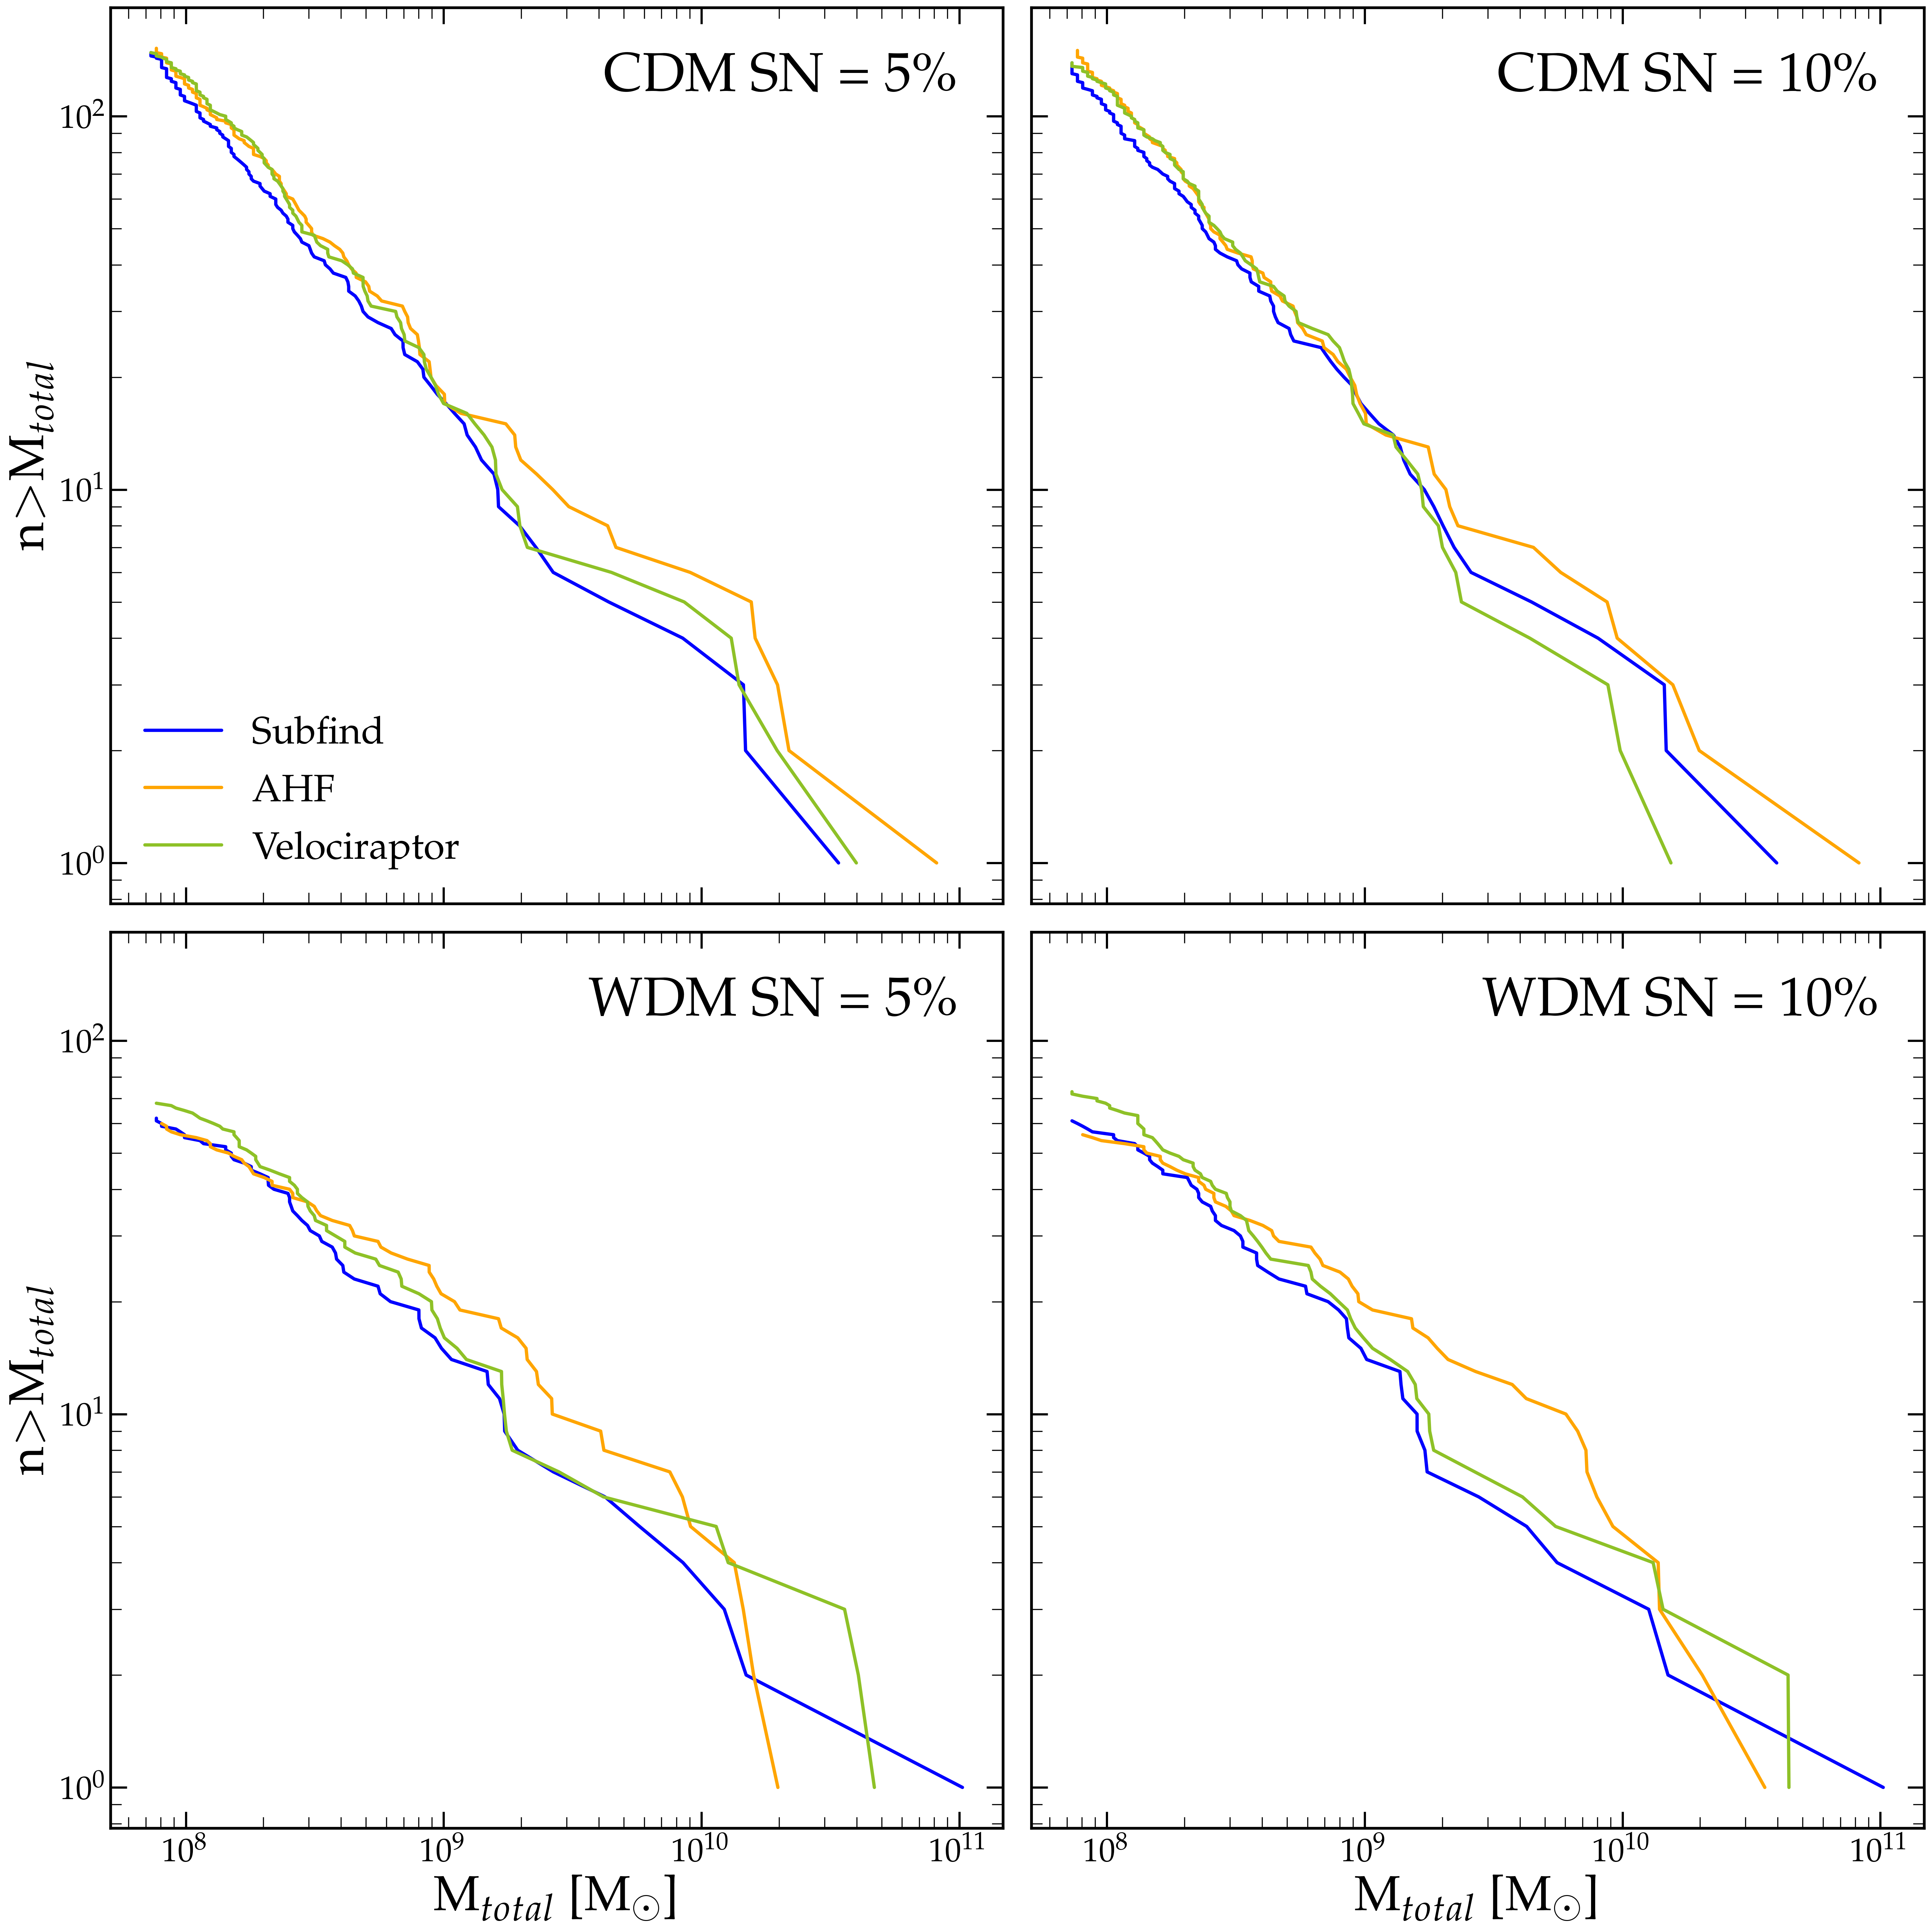

In [ ]:

fig, axs = plt.subplots(2,2,figsize=(25,25),dpi=250,sharex=True,sharey=True)

axs[0,0].plot(SF_all_subs_cdm_005,SF_all_subs_cdm_005_sum,label='Subfind',color='blue')
axs[0,0].plot(MW_all_subhaloes_cdm_005, all_subhalo_cummass_func_ahf_cdm_005, label='AHF',color='orange')
axs[0,0].plot(DM_subs_VR_cdm_005,DM_subs_VR_cdm_005_sum,label='Velociraptor',color=VR_color)

axs[0,1].plot(SF_all_subs_cdm_010,SF_all_subs_cdm_010_sum,color='blue')
axs[0,1].plot(MW_all_subhaloes_cdm_010, all_subhalo_cummass_func_ahf_cdm_010, color='orange')
axs[0,1].plot(DM_subs_VR_cdm_010,DM_subs_VR_cdm_010_sum,color=VR_color)

axs[1,0].plot(SF_all_subs_wdm_005,SF_all_subs_wdm_005_sum,color='blue')
axs[1,0].plot(MW_all_subhaloes_wdm_005, all_subhalo_cummass_func_ahf_wdm_005, color='orange')
axs[1,0].plot(DM_subs_VR_wdm_005,DM_subs_VR_wdm_005_sum,color=VR_color)

axs[1,1].plot(SF_all_subs_wdm_010,SF_all_subs_wdm_010_sum,color='blue')
axs[1,1].plot(MW_all_subhaloes_wdm_010, all_subhalo_cummass_func_ahf_wdm_010, color='orange')
axs[1,1].plot(DM_subs_VR_wdm_010,DM_subs_VR_wdm_010_sum,color=VR_color)

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')

axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel(r'M$_{total}$ [M$_{\odot}$]')
axs[1,1].set_xlabel(r'M$_{total}$ [M$_{\odot}$]')

axs[0,0].set_ylabel(r'n$>$M$_{total}$')
axs[1,0].set_ylabel(r'n$>$M$_{total}$')

axs[0,0].text(0.95,0.95,'CDM SN = 5\%',ha='right', va='top',transform=axs[0,0].transAxes,fontsize=50.0,weight='bold',color='k')
axs[0,1].text(0.95,0.95,'CDM SN = 10\%',ha='right', va='top',transform=axs[0,1].transAxes,fontsize=50.0,weight='bold',color='k')

axs[1,0].text(0.95,0.95,'WDM SN = 5\%',ha='right', va='top',transform=axs[1,0].transAxes,fontsize=50.0,weight='bold',color='k')
axs[1,1].text(0.95,0.95,'WDM SN = 10\%',ha='right', va='top',transform=axs[1,1].transAxes,fontsize=50.0,weight='bold',color='k')

axs[0,0].legend(loc='lower left')
plt.tight_layout()
plt.savefig('./all_hf_all_subs_comp_test.png')
plt.show()



In [ ]:
fig, axs = plt.subplots()
axs.plot(SF_all_subs_cdm_005,SF_all_subs_cdm_005_sum,label='Subfind',color='blue')
axs.plot(MW_all_subhaloes_cdm_005, all_subhalo_cummass_func_ahf_cdm_005, label='AHF',color='orange')
axs.plot(DM_subs_VR_cdm_005,DM_subs_VR_cdm_005_sum,label='Velociraptor',color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
plt.ylim(0.9,2e2)
plt.xlabel(r'M$_{total}$ [M$_{\odot}$]')
plt.ylabel(r'n$>$M$_{total}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('./split_plots/all_hf_all_subs_comp_cdm_05.png',dpi=300)
plt.close()

fig, axs = plt.subplots()
axs.plot(SF_all_subs_cdm_010,SF_all_subs_cdm_010_sum,color='blue')
axs.plot(MW_all_subhaloes_cdm_010, all_subhalo_cummass_func_ahf_cdm_010, color='orange')
axs.plot(DM_subs_VR_cdm_010,DM_subs_VR_cdm_010_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
plt.ylim(0.9,2e2)
plt.xlabel(r'M$_{total}$ [M$_{\odot}$]')
plt.ylabel(r'n$>$M$_{total}$')
# plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('./split_plots/all_hf_all_subs_comp_cdm_10.png',dpi=300)
plt.close()

fig, axs = plt.subplots()
axs.plot(SF_all_subs_wdm_005,SF_all_subs_wdm_005_sum,color='blue')
axs.plot(MW_all_subhaloes_wdm_005, all_subhalo_cummass_func_ahf_wdm_005, color='orange')
axs.plot(DM_subs_VR_wdm_005,DM_subs_VR_wdm_005_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
plt.ylim(0.9,2e2)
plt.xlabel(r'M$_{total}$ [M$_{\odot}$]')
plt.ylabel(r'n$>$M$_{total}$')
# plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('./split_plots/all_hf_all_subs_comp_wdm_05.png',dpi=300)
plt.close()

fig, axs = plt.subplots()
axs.plot(SF_all_subs_wdm_010,SF_all_subs_wdm_010_sum,color='blue')
axs.plot(MW_all_subhaloes_wdm_010, all_subhalo_cummass_func_ahf_wdm_010, color='orange')
axs.plot(DM_subs_VR_wdm_010,DM_subs_VR_wdm_010_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
plt.ylim(0.9,2e2)
plt.xlabel(r'M$_{total}$ [M$_{\odot}$]')
plt.ylabel(r'n$>$M$_{total}$')
# plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('./split_plots/all_hf_all_subs_comp_wdm_10.png',dpi=300)
plt.close()

In [ ]:
stel_subs_VR_cdm_005 = sub_mass_star_cdm_005[sub_mass_star_cdm_005>0]/LITTLEH
stel_subs_VR_cdm_005 = np.sort(stel_subs_VR_cdm_005)[::-1]
stel_subs_VR_cdm_005_sum = np.cumsum(np.ones(len(stel_subs_VR_cdm_005)))

stel_subs_VR_cdm_010 = sub_mass_star_cdm_010[sub_mass_star_cdm_010>0]/LITTLEH
stel_subs_VR_cdm_010 = np.sort(stel_subs_VR_cdm_010)[::-1]
stel_subs_VR_cdm_010_sum = np.cumsum(np.ones(len(stel_subs_VR_cdm_010)))

stel_subs_VR_wdm_005 = sub_mass_star_wdm_005[sub_mass_star_wdm_005>0]/LITTLEH
stel_subs_VR_wdm_005 = np.sort(stel_subs_VR_wdm_005)[::-1]
stel_subs_VR_wdm_005_sum = np.cumsum(np.ones(len(stel_subs_VR_wdm_005)))

stel_subs_VR_wdm_010 = sub_mass_star_wdm_010[sub_mass_star_wdm_010>0]/LITTLEH
stel_subs_VR_wdm_010 = np.sort(stel_subs_VR_wdm_010)[::-1]
stel_subs_VR_wdm_010_sum = np.cumsum(np.ones(len(stel_subs_VR_wdm_010)))


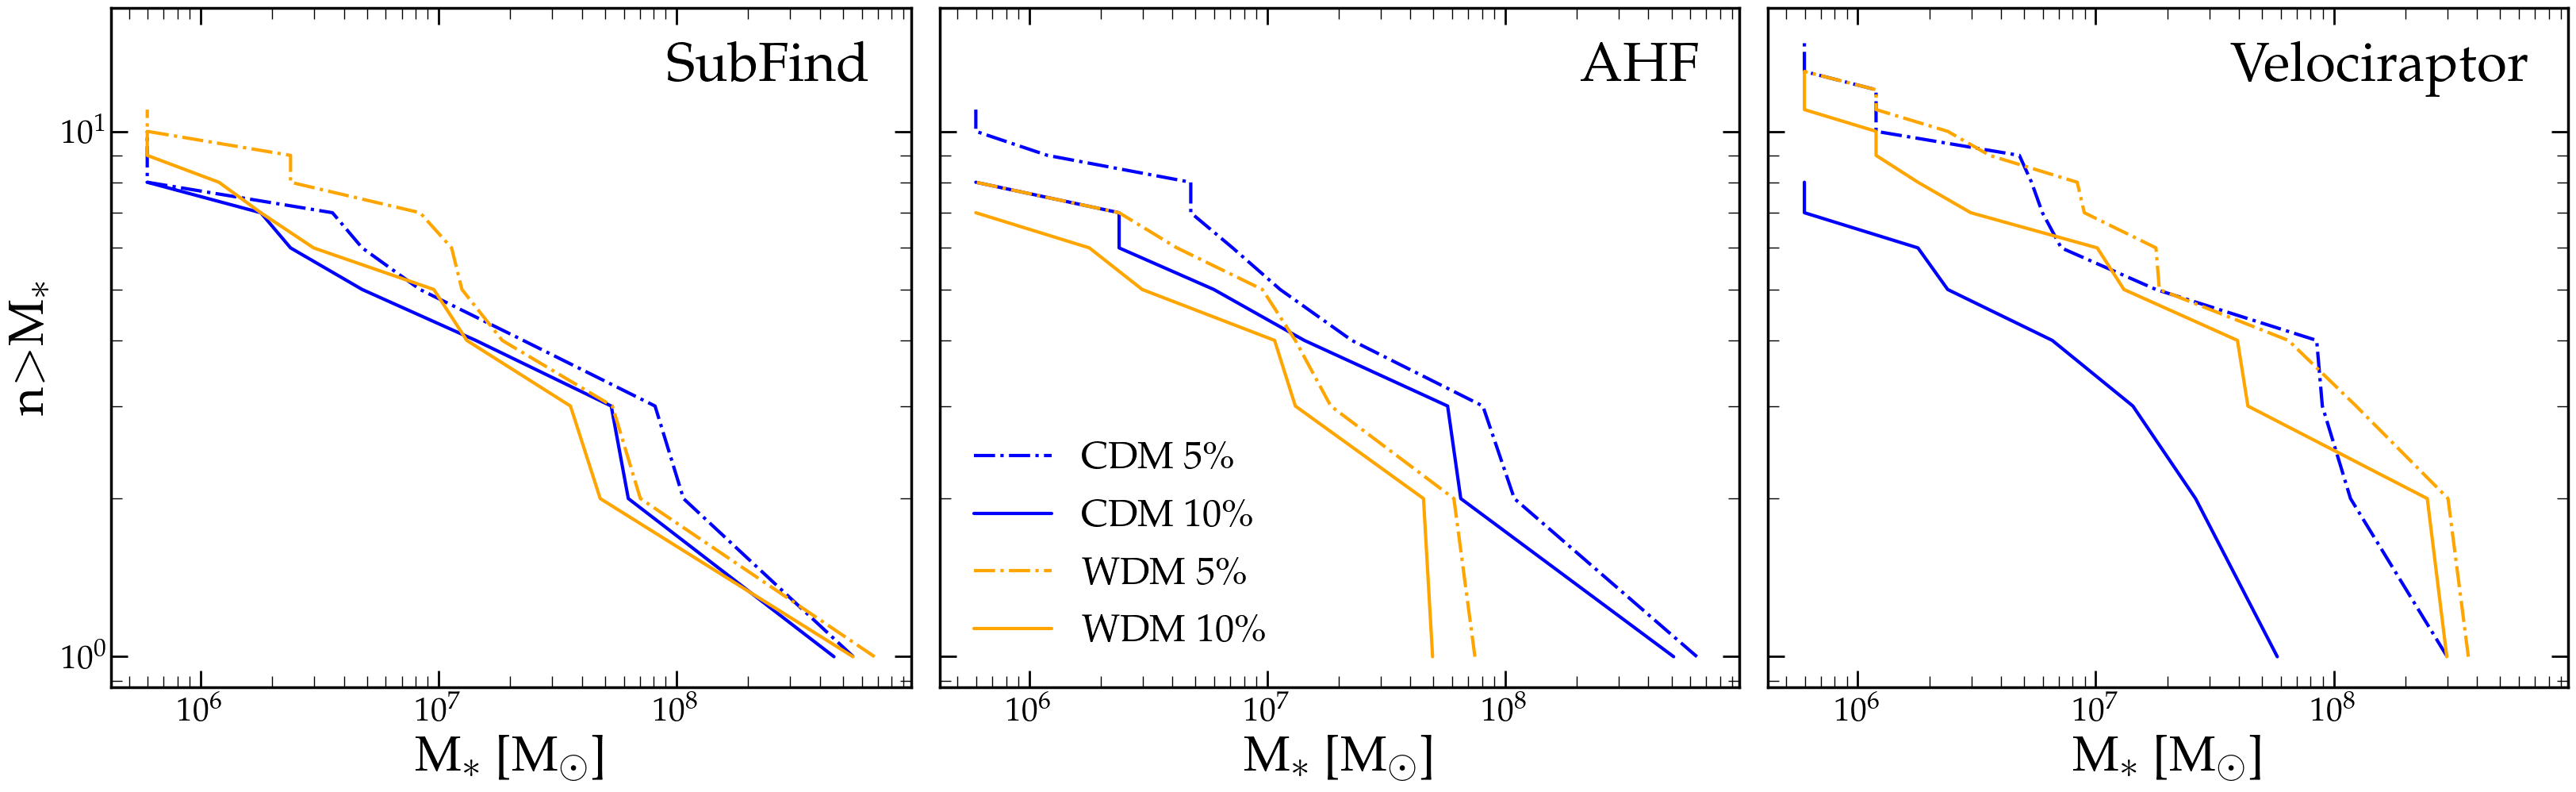

In [ ]:

fig, axs = plt.subplots(1,3,figsize=(33,10.5),sharey=True, sharex=True)

axs[0].plot(star_mass_cdm_005, star_mass_sum_cdm_005,label='cdm 5\%', color='blue', linestyle='-.')
axs[0].plot(star_mass_cdm_010, star_mass_sum_cdm_010,label='cdm 10\%', color='blue')
axs[0].plot(star_mass_wdm_005, star_mass_sum_wdm_005,label='wdm 5\%', color='orange', linestyle='-.')
axs[0].plot(star_mass_wdm_010, star_mass_sum_wdm_010,label='wdm 10\%', color='orange')

axs[1].plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,label='CDM 5\%', color='blue', linestyle='-.')
axs[1].plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,label='CDM 10\%', color='blue')
axs[1].plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005,label='WDM 5\%', color='orange', linestyle='-.')
axs[1].plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010,label='WDM 10\%', color='orange')

axs[2].plot(stel_subs_VR_cdm_005,stel_subs_VR_cdm_005_sum,label='cdm 5\%', color='blue', linestyle='-.')
axs[2].plot(stel_subs_VR_cdm_010,stel_subs_VR_cdm_010_sum,label='cdm 10\%', color='blue')
axs[2].plot(stel_subs_VR_wdm_005,stel_subs_VR_wdm_005_sum,label='wdm 5\%', color='orange', linestyle='-.')
axs[2].plot(stel_subs_VR_wdm_010,stel_subs_VR_wdm_010_sum,label='wdm 10\%', color='orange')

axs[0].set_xscale('log')
axs[0].set_yscale('log')
# axs[0].set_title('Subfind')
axs[0].text(0.95,0.95,'SubFind',ha='right', va='top',transform=axs[0].transAxes,fontsize=50.0,weight='bold',color='k')

axs[1].set_xscale('log')
axs[1].set_yscale('log')
# axs[1].set_title('AHF')
axs[1].text(0.95,0.95,'AHF',ha='right', va='top',transform=axs[1].transAxes,fontsize=50.0,weight='bold',color='k')

axs[2].set_xscale('log')
axs[2].set_yscale('log')
# axs[2].set_title('Velociraptor')
axs[2].text(0.95,0.95,'Velociraptor',ha='right', va='top',transform=axs[2].transAxes,fontsize=50.0,weight='bold',color='k')

axs[0].set_ylabel(r'n$>$M$_{*}$')

axs[0].set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
axs[1].set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
axs[2].set_xlabel(r'M$_{*}$ [M$_{\odot}$]')

axs[1].legend(loc='lower left')
plt.tight_layout()
plt.savefig('./all_hf_sat_comp.png',dpi=200)
plt.show()



In [ ]:

fig, axs = plt.subplots()

axs.plot(star_mass_cdm_005, star_mass_sum_cdm_005,label='CDM 5\%', color='blue', linestyle='-.')
axs.plot(star_mass_cdm_010, star_mass_sum_cdm_010,label='CDM 10\%', color='blue')
axs.plot(star_mass_wdm_005, star_mass_sum_wdm_005,label='WDM 5\%', color='orange', linestyle='-.')
axs.plot(star_mass_wdm_010, star_mass_sum_wdm_010,label='WDM 10\%', color='orange')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_MW_sats_comp_SF.png',dpi=300)
plt.close()

fig, axs = plt.subplots()

axs.plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,label='CDM 5\%', color='blue', linestyle='-.')
axs.plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,label='CDM 10\%', color='blue')
axs.plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005,label='WDM 5\%', color='orange', linestyle='-.')
axs.plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010,label='WDM 10\%', color='orange')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.legend(loc='lower left')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_MW_sats_comp_AHF.png',dpi=300)
plt.close()

fig, axs = plt.subplots()

axs.plot(stel_subs_VR_cdm_005,stel_subs_VR_cdm_005_sum,label='CDM 5\%', color='blue', linestyle='-.')
axs.plot(stel_subs_VR_cdm_010,stel_subs_VR_cdm_010_sum,label='CDM 10\%', color='blue')
axs.plot(stel_subs_VR_wdm_005,stel_subs_VR_wdm_005_sum,label='WDM 5\%', color='orange', linestyle='-.')
axs.plot(stel_subs_VR_wdm_010,stel_subs_VR_wdm_010_sum,label='WDM 10\%', color='orange')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_MW_sats_comp_VR.png',dpi=300)
plt.close()

# axs[0].set_title('Subfind')
# axs[0].text(0.95,0.95,'SubFind',ha='right', va='top',transform=axs[0].transAxes,fontsize=50.0,weight='bold',color='k')
# axs[1].set_title('AHF')
# axs[1].text(0.95,0.95,'AHF',ha='right', va='top',transform=axs[1].transAxes,fontsize=50.0,weight='bold',color='k')
# axs[2].set_title('Velociraptor')
# axs[2].text(0.95,0.95,'Velociraptor',ha='right', va='top',transform=axs[2].transAxes,fontsize=50.0,weight='bold',color='k')


# plt.tight_layout()
# plt.savefig('./all_hf_sat_comp.png',dpi=200)
# plt.show()

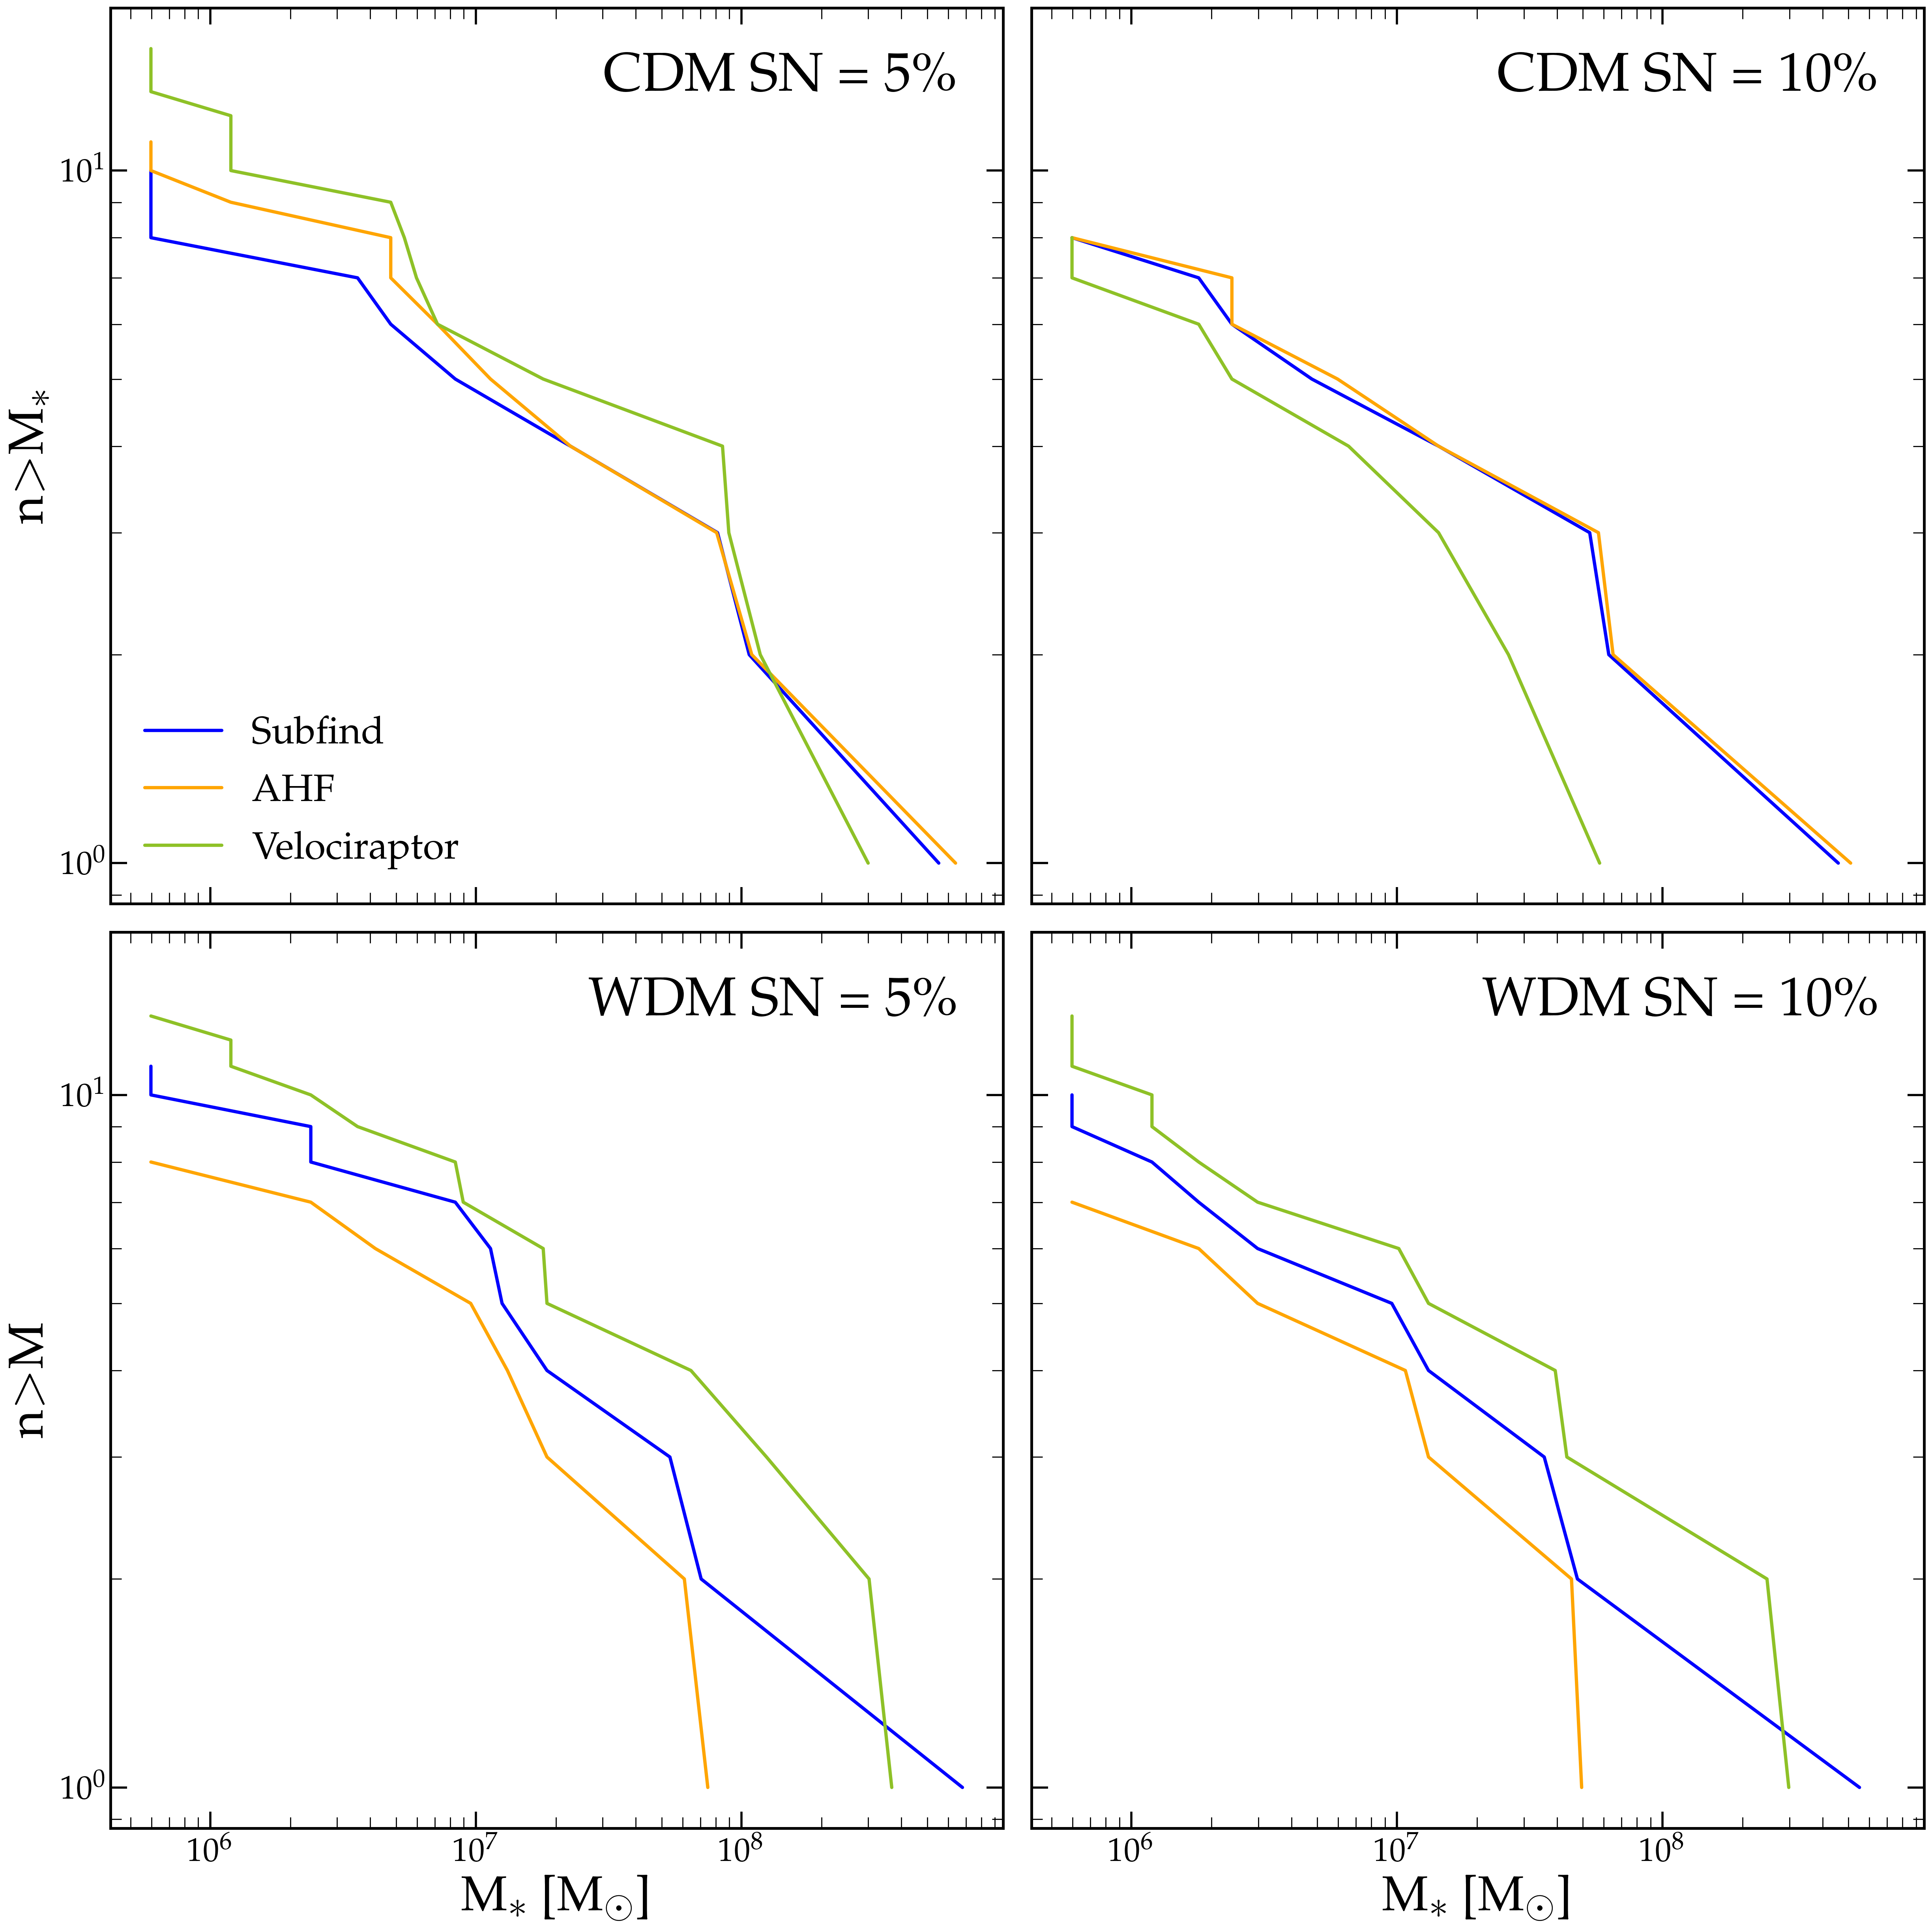

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(25,25),dpi=200, sharex=True, sharey=True)

axs[0,0].plot(star_mass_cdm_005, star_mass_sum_cdm_005, color='blue',label='Subfind')
axs[0,1].plot(star_mass_cdm_010, star_mass_sum_cdm_010,color='blue')
axs[1,0].plot(star_mass_wdm_005, star_mass_sum_wdm_005,color='blue')
axs[1,1].plot(star_mass_wdm_010, star_mass_sum_wdm_010,color='blue')

axs[0,0].plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005, color='orange',label='AHF')
axs[0,1].plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010, color='orange')
axs[1,0].plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005, color='orange')
axs[1,1].plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010, color='orange')

axs[0,0].plot(stel_subs_VR_cdm_005,stel_subs_VR_cdm_005_sum,color=VR_color,label='Velociraptor')
axs[0,1].plot(stel_subs_VR_cdm_010,stel_subs_VR_cdm_010_sum,color=VR_color)
axs[1,0].plot(stel_subs_VR_wdm_005,stel_subs_VR_wdm_005_sum,color=VR_color)
axs[1,1].plot(stel_subs_VR_wdm_010,stel_subs_VR_wdm_010_sum,color=VR_color)

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')

axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

# axs[0,0].set_title('CDM SN = 5\%')
axs[0,0].text(0.95,0.95,'CDM SN = 5\%',ha='right', va='top',transform=axs[0,0].transAxes,fontsize=50.0,weight='bold',color='k')
# axs[0,1].set_title('CDM SN = 10\%')
axs[0,1].text(0.95,0.95,'CDM SN = 10\%',ha='right', va='top',transform=axs[0,1].transAxes,fontsize=50.0,weight='bold',color='k')

# axs[1,0].set_title('WDM SN = 5\%')
axs[1,0].text(0.95,0.95,'WDM SN = 5\%',ha='right', va='top',transform=axs[1,0].transAxes,fontsize=50.0,weight='bold',color='k')
# axs[1,1].set_title('WDM SN = 10\%')
axs[1,1].text(0.95,0.95,'WDM SN = 10\%',ha='right', va='top',transform=axs[1,1].transAxes,fontsize=50.0,weight='bold',color='k')

axs[0,0].set_ylabel(r'n$>$M$_{*}$')
axs[1,0].set_ylabel(r'n$>$M')

axs[1,0].set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
axs[1,1].set_xlabel(r'M$_{*}$ [M$_{\odot}$]')

axs[0,0].legend(loc='lower left')
plt.tight_layout()
plt.savefig('./all_hf_sim_sat_comp.png',dpi=200)
plt.show()


In [ ]:

fig, axs = plt.subplots()

axs.plot(star_mass_cdm_005, star_mass_sum_cdm_005, color='blue',label='Subfind')
axs.plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005, color='orange',label='AHF')
axs.plot(stel_subs_VR_cdm_005,stel_subs_VR_cdm_005_sum,color=VR_color,label='Velociraptor')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
axs.legend(loc='lower left')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_sim_sat_comp_cdm_05.png',dpi=300)
plt.close()

fig, axs = plt.subplots()

axs.plot(star_mass_cdm_010, star_mass_sum_cdm_010,color='blue')
axs.plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010, color='orange')
axs.plot(stel_subs_VR_cdm_010,stel_subs_VR_cdm_010_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_sim_sat_comp_cdm_10.png',dpi=300)
plt.close()

fig, axs = plt.subplots()

axs.plot(star_mass_wdm_005, star_mass_sum_wdm_005,color='blue')
axs.plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005, color='orange')
axs.plot(stel_subs_VR_wdm_005,stel_subs_VR_wdm_005_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_sim_sat_comp_wdm_05.png',dpi=300)
plt.close()

fig, axs = plt.subplots()

axs.plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010, color='orange')
axs.plot(star_mass_wdm_010, star_mass_sum_wdm_010,color='blue')
axs.plot(stel_subs_VR_wdm_010,stel_subs_VR_wdm_010_sum,color=VR_color)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'n$>$M$_{*}$')
axs.set_xlabel(r'M$_{*}$ [M$_{\odot}$]')
plt.ylim(0.9,16)
plt.tight_layout()
plt.savefig('./split_plots/all_hf_sim_sat_comp_wdm_10.png',dpi=300)
plt.close()


# plt.tight_layout()
# plt.savefig('./all_hf_sim_sat_comp.png',dpi=200)
# plt.show()

In [ ]:
print('Number of satellites for CDM SN 5%:')
print(f"SubFindHBT   = {np.max(star_mass_sum_cdm_005)}")
print(f"AHF          = {np.max(subhalo_cummass_func_ahf_cdm_005)}")
print(f"Velociraptor = {np.max(stel_subs_VR_cdm_005_sum)}")

print('\nNumber of satellites for CDM SN 10%:')
print(f"SubFindHBT   = {np.max(star_mass_sum_cdm_010)}")
print(f"AHF          = {np.max(subhalo_cummass_func_ahf_cdm_010)}")
print(f"Velociraptor = {np.max(stel_subs_VR_cdm_010_sum)}")

print('\nNumber of satellites for WDM SN 5%:')
print(f"SubFindHBT   = {np.max(star_mass_sum_wdm_005)}")
print(f"AHF          = {np.max(subhalo_cummass_func_ahf_wdm_005)}")
print(f"Velociraptor = {np.max(stel_subs_VR_wdm_005_sum)}")

print('\nNumber of satellites for WDM SN 10%:')
print(f"SubFindHBT   = {np.max(star_mass_sum_wdm_010)}")
print(f"AHF          = {np.max(subhalo_cummass_func_ahf_wdm_010)}")
print(f"Velociraptor = {np.max(stel_subs_VR_wdm_010_sum)}")

Number of satellites for CDM SN 5%:
SubFindHBT   = 10.0
AHF          = 11.0
Velociraptor = 15.0

Number of satellites for CDM SN 10%:
SubFindHBT   = 8.0
AHF          = 8.0
Velociraptor = 8.0

Number of satellites for WDM SN 5%:
SubFindHBT   = 11.0
AHF          = 8.0
Velociraptor = 13.0

Number of satellites for WDM SN 10%:
SubFindHBT   = 10.0
AHF          = 7.0
Velociraptor = 13.0


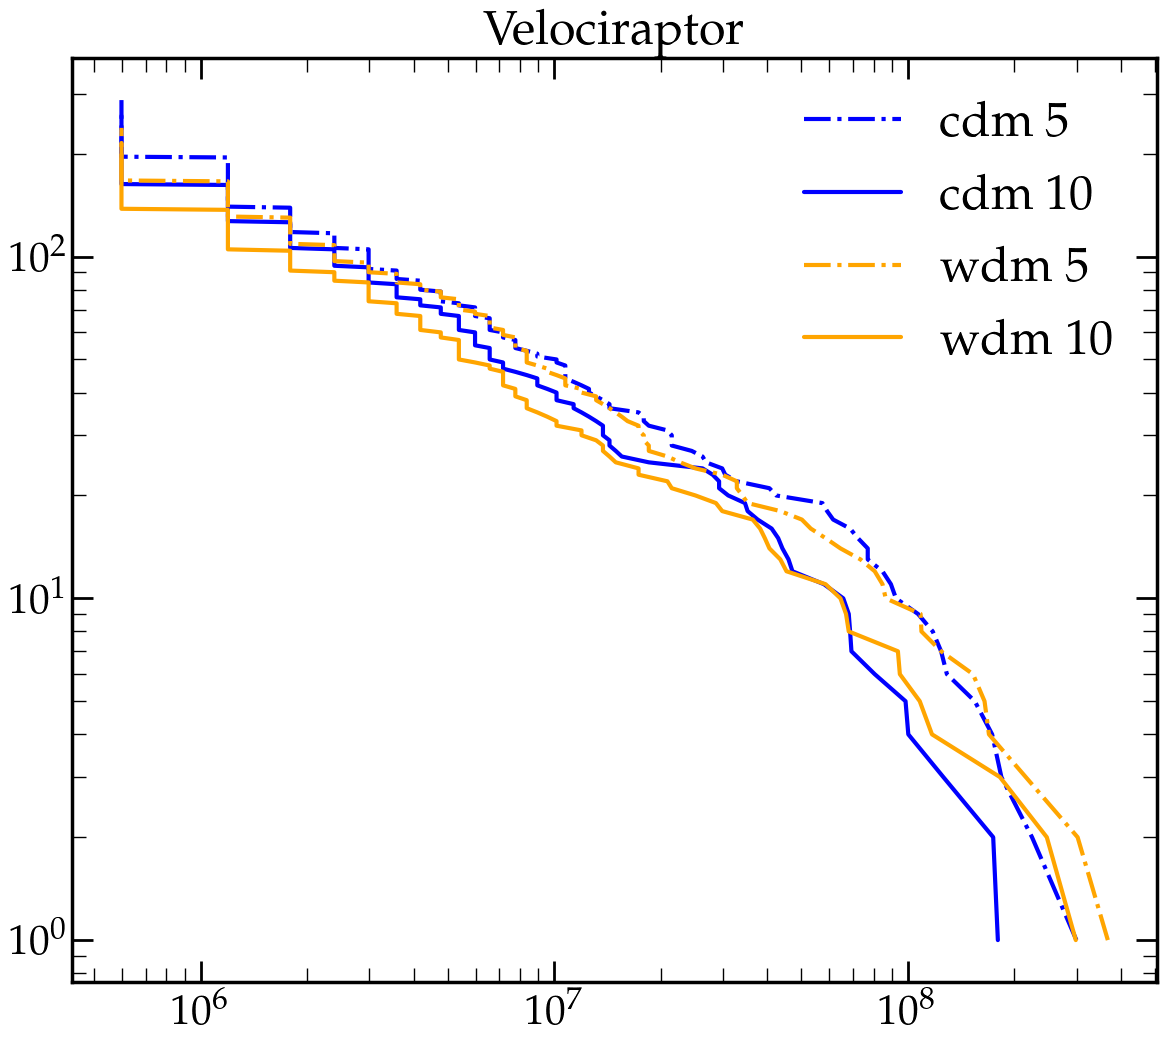

In [ ]:
stel_subs_VR_cdm_005 = np.array(VR_subhalo_data_cdm_005['Mass_star'])[np.array(VR_subhalo_data_cdm_005['Mass_star'])>0]/LITTLEH*1e10
stel_subs_VR_cdm_005 = np.sort(stel_subs_VR_cdm_005)[::-1]
stel_subs_VR_cdm_005_sum = np.cumsum(np.ones(len(stel_subs_VR_cdm_005)))

stel_subs_VR_cdm_010 = np.array(VR_subhalo_data_cdm_010['Mass_star'])[np.array(VR_subhalo_data_cdm_010['Mass_star'])>0]/LITTLEH*1e10
stel_subs_VR_cdm_010 = np.sort(stel_subs_VR_cdm_010)[::-1]
stel_subs_VR_cdm_010_sum = np.cumsum(np.ones(len(stel_subs_VR_cdm_010)))

stel_subs_VR_wdm_005 = np.array(VR_subhalo_data_wdm_005['Mass_star'])[np.array(VR_subhalo_data_wdm_005['Mass_star'])>0]/LITTLEH*1e10
stel_subs_VR_wdm_005 = np.sort(stel_subs_VR_wdm_005)[::-1]
stel_subs_VR_wdm_005_sum = np.cumsum(np.ones(len(stel_subs_VR_wdm_005)))

stel_subs_VR_wdm_010 = np.array(VR_subhalo_data_wdm_010['Mass_star'])[np.array(VR_subhalo_data_wdm_010['Mass_star'])>0]/LITTLEH*1e10
stel_subs_VR_wdm_010 = np.sort(stel_subs_VR_wdm_010)[::-1]
stel_subs_VR_wdm_010_sum = np.cumsum(np.ones(len(stel_subs_VR_wdm_010)))

fig, axs = plt.subplots()

# axs[0].plot(star_mass_cdm_005, star_mass_sum_cdm_005,label='cdm 5%', color='blue', linestyle='-.')
# axs[0].plot(star_mass_cdm_010, star_mass_sum_cdm_010,label='cdm 10%', color='blue')
# axs[0].plot(star_mass_wdm_005, star_mass_sum_wdm_005,label='wdm 5%', color='orange', linestyle='-.')
# axs[0].plot(star_mass_wdm_010, star_mass_sum_wdm_010,label='wdm 10%', color='orange')

# axs[1].plot(MH_subhaloes_cdm_005,subhalo_cummass_func_ahf_cdm_005,label='cdm 5%', color='blue', linestyle='-.')
# axs[1].plot(MH_subhaloes_cdm_010,subhalo_cummass_func_ahf_cdm_010,label='cdm 10%', color='blue')
# axs[1].plot(MH_subhaloes_wdm_005,subhalo_cummass_func_ahf_wdm_005,label='wdm 5%', color='orange', linestyle='-.')
# axs[1].plot(MH_subhaloes_wdm_010,subhalo_cummass_func_ahf_wdm_010,label='wdm 10%', color='orange')

axs.plot(stel_subs_VR_cdm_005,stel_subs_VR_cdm_005_sum,label='cdm 5%', color='blue', linestyle='-.')
axs.plot(stel_subs_VR_cdm_010,stel_subs_VR_cdm_010_sum,label='cdm 10%', color='blue')
axs.plot(stel_subs_VR_wdm_005,stel_subs_VR_wdm_005_sum,label='wdm 5%', color='orange', linestyle='-.')
axs.plot(stel_subs_VR_wdm_010,stel_subs_VR_wdm_010_sum,label='wdm 10%', color='orange')

# axs[0].set_xscale('log')
# axs[0].set_yscale('log')
# axs[0].set_title('Subfind')

# axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_title('AHF')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_title('Velociraptor')


axs.legend()
plt.show()